In [32]:
%pip install openai pillow



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [120]:
from openai import OpenAI
import pandas as pd
import json

from ultralytics import YOLO
import os
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import base64

In [2]:
# Load api Key
def get_credentials() -> dict:
    # loads openai credentials from local config.json file
    with open('config.json', 'r') as f:
        config = json.load(f)
    return config

In [3]:
config = get_credentials()

In [4]:

client = OpenAI(
  api_key=config['open_api_key'],  # this is also the default, it can be omitted
)

In [91]:
LLM_MODEL = "gpt-4o-mini"
model = YOLO("yolo11n.pt")

In [96]:
INTERIOR_CLASSES = {
    13: ('bench', (0, 255, 255)),          # Yellow
    56: ('chair', (255, 0, 0)),            # Red
    57: ('couch', (0, 255, 0)),            # Green
    58: ('potted plant', (255, 165, 0)),   # Orange
    59: ('bed', (255, 0, 255)),            # Magenta
    60: ('dining table', (0, 0, 255)),     # Blue
    61: ('toilet', (0, 128, 255)),         # Light Orange
    62: ('tv', (128, 0, 128)),             # Purple
    63: ('laptop', (0, 255, 128)),         # Light Green
    67: ('cell phone', (255, 192, 203)),   # Pink
    72: ('refrigerator', (0, 128, 0)),     # Dark Green
    75: ('vase', (128, 128, 0))            # Olive
}


## Helper Functions

In [131]:
furniture_list = {INTERIOR_CLASSES[key][0] for key in INTERIOR_CLASSES}
print(furniture_list )


prompt = f"""
Based on Feng Shui principles, provide recommendations to improve the energy flow and harmony of the room. 
Only output the recommendations in JSON format with keys as the names of the furniture you have suggestions for.
classes: {furniture_list}
"""

{'chair', 'vase', 'bench', 'potted plant', 'couch', 'bed', 'toilet', 'cell phone', 'refrigerator', 'dining table', 'tv', 'laptop'}


In [121]:
def encode_image(image):
    _, buffer = cv2.imencode('.jpg', image)
    return base64.b64encode(buffer).decode('utf-8')

In [125]:
def get_gpt4_completion_with_image(image, prompt):
    base64_image = encode_image(image)
    image_data_url = f"data:image/jpeg;base64,{base64_image}"
    
    completion = client.chat.completions.create(
        
        model=LLM_MODEL,
        messages=[
            {"role": "system", "content": "You are a Feng Shui expert who helps customers re-arrange their room according to Feng Shui principles."},
            {"role": "user",
             "content": [
                        {
                            "type": "text",
                            "text": prompt,
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": image_data_url
                            },
                        },
                    ], 
             },
        ],
        response_format= { "type": "json_object" },
        max_tokens=200,
    )

    try:
        response_json = json.loads(completion.model_dump_json(indent=2))
        content_json = json.loads(response_json['choices'][0]['message']['content'])
        return content_json
    except Exception as e:
        return None


#### Get Annotated Image

In [102]:
def detect_objects(image):
    """
    Implemented custom detection and drawing of bounding boxes.
    Only drawing items if they are in INTERIOR CLASSES. removed the confidence score to simplify image 
    """
    results = model(image)
    detected_items = []
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)
            if class_id in INTERIOR_CLASSES:
                label, color = INTERIOR_CLASSES[class_id]
                detected_items.append(label)  
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                image = cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, lineType=cv2.LINE_AA)
    annotated_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return annotated_image, detected_items

In [13]:
with open('data/data.yaml', 'r') as file:
    config = yaml.safe_load(file)

test_path = config['test']

print("Test Path:", test_path)

Test Path: data/test/images


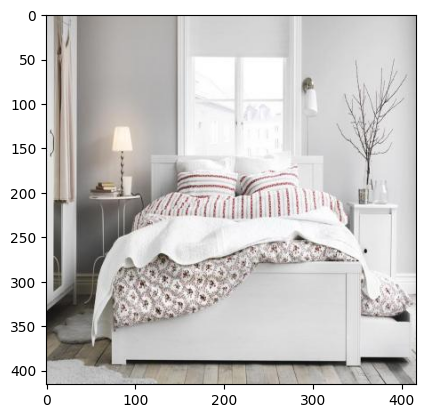

In [16]:
sample_image_path = os.path.join(test_path, os.listdir(test_path)[10])
image = Image.open(sample_image_path)


0: 640x640 1 potted plant, 1 bed, 56.8ms
Speed: 6.2ms preprocess, 56.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


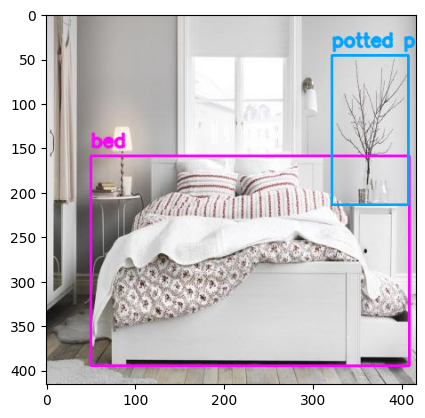

['bed', 'potted plant']


In [106]:
image = cv2.imread(sample_image_path)

annotated_image, detected_items = detect_objects(image)
plt.imshow(annotated_image)
plt.show()
print(detected_items)

In [126]:
resp = get_gpt4_completion_with_image(annotated_image, prompt)


In [128]:
print(resp)

{'bed': 'Ensure the bed is accessible from both sides, not aligned directly with the door, and has a solid headboard for support.', 'potted plant': 'Place the potted plant in a corner to enhance fresh energy and balance. Make sure it receives enough light.'}
